# Rock Paper Scissors - Pytorch Multiclass Classifier
In this workbook we illustrate multi-class image classification of the [Rock Paper Scissors dataset](https://www.kaggle.com/drgfreeman/rockpaperscissors), which is downloaded from Kaggle from the above URL. You'll need to login with your Kaggle ID to download the dataset. The data was downloaded and un-zipped to the `./data/RockPaperScissors` folder

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torchvision import transforms 
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
#import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.13.0+cpu. GPU is NOT available


In [2]:
CLASSES = ['rock', 'paper', 'scissors']

In [3]:
def get_data(image_paths):
    images, labels = [], []

    for image_path in image_paths:
        image = load_img(image_path, target_size=(32,32), color_mode='grayscale')
        image = img_to_array(image)
        label_name = image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)

        #labels = np.expand_dims(labels, axis=0)

    return np.array(images), np.array(labels)

In [4]:
file_pattern = pathlib.Path.cwd() / 'data' / 'RockPaperScissors' /  '*' / '*.png'
dataset_paths = [*glob.glob(str(file_pattern))]
random.shuffle(dataset_paths)
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (2188, 32, 32, 1) - labels.shape: (2188,)


In [5]:
dataset_paths[:10]

['C:\\Users\\bapti\\OneDrive\\Documents\\Etudes\\2022-23 ESILV A5\\Bamberg\\Semester\\Masterprojekt Erklärbares Maschinelles Lernen\\Proj\\dl-pytorch-master\\dl-pytorch-master\\data\\RockPaperScissors\\scissors\\TNOQ2IEy4C6LBSD1.png',
 'C:\\Users\\bapti\\OneDrive\\Documents\\Etudes\\2022-23 ESILV A5\\Bamberg\\Semester\\Masterprojekt Erklärbares Maschinelles Lernen\\Proj\\dl-pytorch-master\\dl-pytorch-master\\data\\RockPaperScissors\\rock\\SNEJ1wGU1s9Dm3I1.png',
 'C:\\Users\\bapti\\OneDrive\\Documents\\Etudes\\2022-23 ESILV A5\\Bamberg\\Semester\\Masterprojekt Erklärbares Maschinelles Lernen\\Proj\\dl-pytorch-master\\dl-pytorch-master\\data\\RockPaperScissors\\rock\\Q2rRUGWBDy47XucJ.png',
 'C:\\Users\\bapti\\OneDrive\\Documents\\Etudes\\2022-23 ESILV A5\\Bamberg\\Semester\\Masterprojekt Erklärbares Maschinelles Lernen\\Proj\\dl-pytorch-master\\dl-pytorch-master\\data\\RockPaperScissors\\rock\\zrrYLvM2uywyFwRy.png',
 'C:\\Users\\bapti\\OneDrive\\Documents\\Etudes\\2022-23 ESILV A5\\Bambe

In [6]:
np.bincount(labels.astype('int32')), labels[:10]

(array([726, 712, 750], dtype=int64), array([2, 0, 0, 0, 2, 0, 2, 0, 1, 1]))

In [7]:
def build_model():
    net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),       

        nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),     

        nn.Flatten(),

        nn.Linear(64*2*2, 500),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(500, 3)
    )

    return net

In [8]:
from sklearn.model_selection import train_test_split

# split dataset into train/test sets in 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, 
                                                    random_state=SEED, stratify=labels)
# split the test set into cross-val & test datasets in 80:20 rstio
# NOTE: Andrew Ng recommends that, if possible, the test & cv datasets should be drawn
# from the same sample
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, 
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (1531, 32, 32, 1) - y_train.shape: (1531,) - class dist: [508 498 525]
X_val.shape: (459, 32, 32, 1) - y_val.shape: (459,) - class dist: [152 150 157]
X_test.shape: (198, 32, 32, 1) - y_test.shape: (198,) - class dist: [66 64 68]


In [9]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),     
])
    
image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [10]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


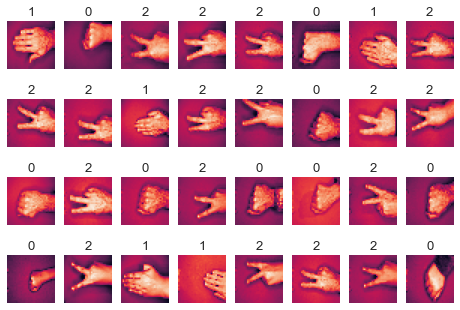

In [11]:
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    label = sample_labels[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.title(label)
    plt.axis('off')
plt.show()
plt.close()

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


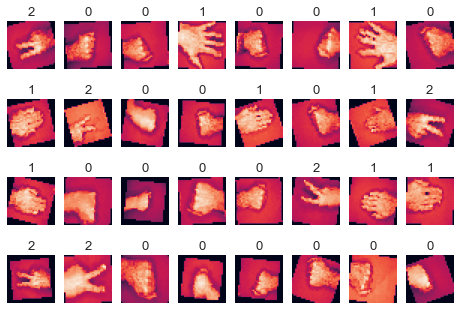

In [12]:
testloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    label = sample_labels[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.title(label)
    plt.axis('off')
plt.show()
plt.close()

In [13]:
net = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
#optimizer = optim.SGD(params=model.parameters(), lr=0.001)

In [14]:
class Classifier():
    def __init__(self):
        """
        constructs the Classifier
        """
        self.net = build_model()
        
    def train(self, trainloader, criterion, optimizer):
        for epoch in range(5):  # loop over the dataset multiple time
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        print('Finished Training')
                
    def evaluate(self, testloader):
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = self.net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the {len(testloader.dataset)} test images: {100 * correct // total} %')

In [15]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
classifier = Classifier()
classifier.train(trainloader, criterion, optimizer)

Finished Training


In [17]:
classifier.evaluate(testloader)

Accuracy of the network on the 1531 test images: 32 %


In [18]:
classifier.evaluate(trainloader)

Accuracy of the network on the 1531 test images: 32 %


In [19]:
classifier.net

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.4, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.4, inplace=False)
  (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.4, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=256, out_features=500, bias=True)
  (

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [21]:
#dataiter = iter(testloader)
dataiter = iter(trainloader)

images, labels = next(dataiter)
print('GroundTruth: ', ' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(10)))

GroundTruth:  rock  scissors rock  scissors paper scissors paper scissors rock  scissors


In [22]:
outputs = classifier.net(images)

In [23]:
outputs

tensor([[ 0.3698,  0.6167,  0.6751],
        [ 1.0864,  0.3993,  0.4693],
        [ 0.3738,  0.4144,  0.4602],
        [ 0.8478,  0.5250,  0.6888],
        [ 0.0627,  0.0897,  0.4796],
        [ 0.3699,  1.4122,  0.6639],
        [ 0.8709,  0.1324,  0.2708],
        [-0.1500,  1.0327,  0.1878],
        [-0.2211,  1.3156,  0.7752],
        [-0.0332,  0.7093,  0.0028],
        [-0.2174, -0.8615,  0.4963],
        [ 0.7846,  0.5193,  1.3039],
        [ 0.1097,  0.0989,  0.5659],
        [-0.0819,  1.4134,  0.1408],
        [-0.9997,  0.7131,  0.2465],
        [ 0.2381,  0.7492, -1.3731],
        [ 0.8003,  0.9871,  0.6451],
        [-0.0726,  0.4433,  0.7423],
        [ 0.4521,  1.6191,  0.0460],
        [ 0.9741,  0.8292,  0.3363],
        [ 0.7114,  1.4621,  0.2151],
        [ 1.2447,  0.2747,  0.2807],
        [ 1.3042,  0.6017, -0.7221],
        [ 2.3208,  0.8975,  0.5244],
        [ 0.4719,  1.7543, -0.4759],
        [ 0.0371,  0.4189,  0.2700],
        [ 0.7282, -0.0771,  0.0858],
 

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{CLASSES[predicted[j]]:5s}'
                              for j in range(10)))

Predicted:  scissors rock  scissors rock  scissors paper rock  paper paper paper


In [25]:
predicted

tensor([2, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 2, 2, 0, 1])

In [26]:
labels

tensor([0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2,
        0, 1, 2, 1, 2, 1, 1, 1])

In [27]:
print(f"We got {(predicted == labels).sum()} of {len(labels)} correct!")

We got 8 of 32 correct!
